<a href="https://colab.research.google.com/github/WojciechMojsiejuk/Artificial_Intelligence_SEOULTECH/blob/main/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment #3

* Release date: 2022/10/25 Tue
* Due date: **2022/11/01 Tue 23:59** (will not accept late submission)
* Submittion format: notebook file which can be executed in Colab environment
* Weighting: 10% (total 100 pts)

* We will train CNN using `dogs_vs_cats_subset.zip` distributed in the class.

> ### (5pts) Prepare the dataset

* Place the unzipped files in some directory on your Colab instance.
* Count the number of JPEG files in `train`, `validation`, and `test` folders.

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# unzip
import zipfile, os

path_to_zip = '/content/gdrive/MyDrive/Artificial_Intelligence/dogs_vs_cats_subset.zip'
dst_path = '/content/gdrive/MyDrive/Artificial_Intelligence/dataset'

if not os.path.exists(dst_path):
  os.makedirs(dst_path)
  with zipfile.ZipFile(path_to_zip, 'r') as file:
    file.extractall(dst_path)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = os.path.join(dst_path, 'subset/train')
test_path = os.path.join(dst_path, 'subset/test')
validation_path = os.path.join(dst_path, 'subset/validation')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(128,128),
                                                    batch_size=20,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_path,
                                                        target_size=(128,128),
                                                        batch_size=20,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_path,
                                                        target_size=(128,128),
                                                        batch_size=20,
                                                        class_mode='categorical')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


There is 2000 images in training folder, and 1000 images in test and validation folders each.

data batch shape: (20, 128, 128, 3)
labels batch shape: (20, 2)
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


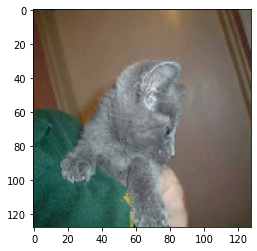

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  plt.imshow(image.array_to_img(data_batch[0]))
  print(labels_batch)
  break
  

> ### (20pts) Build a baseline model

* **(10pts)** Use VGG16 model as a baseline model.
  * You can use `tensorflow.keras.applications` module to get the VGG16 architecture.
  * You should customize the VGG16 model to deal with a given task, i.e., two class classification.
  * We will use 128*128 resized images as inputs to the model and randomly initialized model parameters.
  * Place **two output nodes** at the output layer.
  * Others not specified should be chosen yourself.

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights=None, # randomly initialized parameters
                  include_top=False,
                  input_shape=(128, 128, 3))

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) # we must flatten the convolution layers to 1D array for Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax')) # because we need to have two nodes as an output we must use softmax activation function, rather then sigmoid used for 1 

* **(10pts)** How many trainable parameters in the first convolutional layer? Explain how to compute the number of parameters.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

We can see that for the first convolution layer we have 1792 parameters. Let's get this layer and check its configuration

In [ ]:
first_layer = conv_base.get_layer('block1_conv1')

In [ ]:
first_layer.kernel_size

(3, 3)

In [ ]:
first_layer.input.shape

TensorShape([None, 128, 128, 3])

In [ ]:
first_layer.output.shape

TensorShape([None, 128, 128, 64])

To compute numbers of parameters we must know the size of the kernel, size of the filter in the previous element of the model (input of this layer). After multiplying those three values we must add 1 for bias, and then finally multiply everything for the filter of this layer (which goest to the layer output)
[Source](https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d)

In [ ]:
((first_layer.kernel_size[0] * first_layer.kernel_size[1] * first_layer.input.shape[3]) + 1 ) * first_layer.output.shape[3]

1792

As we can see, we obtained the same number

> ### (10pts) Train a baseline model 

  * Currently, the data is stored as JPEG files. So we need the following steps:
    * Read the files.
    * Decode the JPEG content to RGB grids of pixels.
    * Convert these into floating-point tensors.
    * Scaling the data to be in a range of [0,1].
    
  * Set `batch_size` to 20.
  * Train the network for 50 epochs. It may consume some time. Note that you should set `steps_per_epoch` and `validation_steps` properly so that a particular data is processed once during a single epoch.
  * **Use Adam optimizer to train the model**. You may need to find hyperparameters (e.g., learning rate) to make the optimizer work.
  * Here, you don't need to apply any regularization methods. 

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=2e-5,), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
100/100 [==============================] - 440s 4s/step - loss: 0.6932 - acc: 0.5025 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 2/50
100/100 [==============================] - 16s 155ms/step - loss: 0.6919 - acc: 0.5235 - val_loss: 0.6900 - val_acc: 0.5090
Epoch 3/50
100/100 [==============================] - 16s 155ms/step - loss: 0.6711 - acc: 0.5970 - val_loss: 0.6554 - val_acc: 0.6030
Epoch 4/50
100/100 [==============================] - 16s 163ms/step - loss: 0.6303 - acc: 0.6525 - val_loss: 0.6262 - val_acc: 0.6430
Epoch 5/50
100/100 [==============================] - 15s 153ms/step - loss: 0.6020 - acc: 0.6920 - val_loss: 0.6310 - val_acc: 0.6330
Epoch 6/50
100/100 [==============================] - 15s 154ms/step - loss: 0.5682 - acc: 0.7170 - val_loss: 0.6036 - val_acc: 0.6910
Epoch 7/50
100/100 [==============================] - 15s 153ms/step - loss: 0.5577 - acc: 0.7260 - val_loss: 0.6335 - val_acc: 0.6690
Epoch 8/50
100/100 [==============================] - 15s

In [ ]:
model.save('/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_1.h5')

> ### (5pts) Plot some curves
* Plot accuracies and losses on training and validation datasets, respectively.

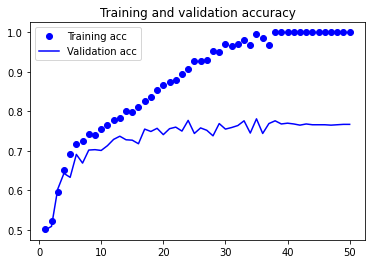

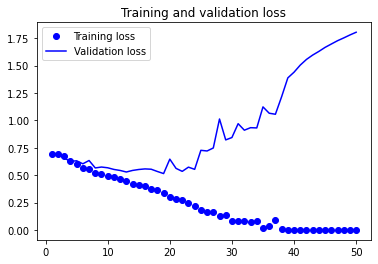

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

> ### (50pts) Improve the baseline model
* Try at least three strategies to improve the validation performance of the baseline model.
* You should examine that the performance is indeed improved as you employ your strategies. In other words, you should show that (accuracy with strategy 1 <= accuracy with strategy 1 and 2 <= accuracy with strategy 1, 2, and 3).

>> ### (15pts) Trial 1: Data augmentetion to improve generalization

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


In [ ]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(128,128),
                                                    batch_size=20,
                                                    class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
100/100 [==============================] - 23s 227ms/step - loss: 0.7456 - acc: 0.5905 - val_loss: 0.6402 - val_acc: 0.6400
Epoch 2/50
100/100 [==============================] - 22s 217ms/step - loss: 0.6210 - acc: 0.6460 - val_loss: 0.5673 - val_acc: 0.7060
Epoch 3/50
100/100 [==============================] - 22s 215ms/step - loss: 0.5762 - acc: 0.6985 - val_loss: 0.5504 - val_acc: 0.7150
Epoch 4/50
100/100 [==============================] - 22s 215ms/step - loss: 0.5471 - acc: 0.7210 - val_loss: 0.5594 - val_acc: 0.7180
Epoch 5/50
100/100 [==============================] - 21s 214ms/step - loss: 0.5358 - acc: 0.7255 - val_loss: 0.5141 - val_acc: 0.7410
Epoch 6/50
100/100 [==============================] - 21s 212ms/step - loss: 0.5104 - acc: 0.7470 - val_loss: 0.5115 - val_acc: 0.7460
Epoch 7/50
100/100 [==============================] - 21s 213ms/step - loss: 0.4856 - acc: 0.7625 - val_loss: 0.5012 - val_acc: 0.7640
Epoch 8/50
100/100 [==============================] - 2

In [ ]:
model.save('/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_2.h5')

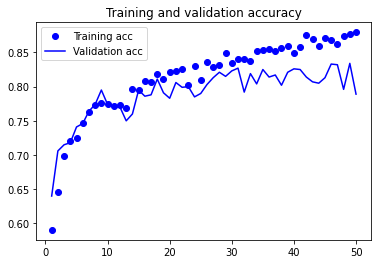

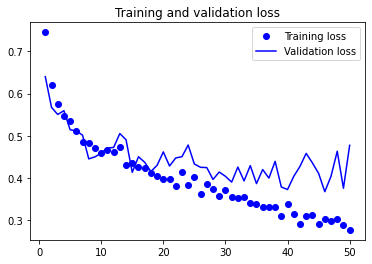

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

>> ### (15pts) Trial 2: trial1 + ImageNet

We need to tune-in data augmentation, because our approach was too strong comparable to the real data we got higher accuracy on validation than on training

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(128,128),
                                                    batch_size=20,
                                                    class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint

# save best epoch before it starts to overfit
modelckpt = ModelCheckpoint(
    monitor = 'val_acc',
    save_best_only=True,
    filepath='/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_3.h5')


conv_base = VGG16(weights='imagenet', # ImageNet pretrained weights
                  include_top=False,
                  input_shape=(128, 128, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) # we must flatten the convolution layers to 1D array for Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax')) # because we need to have two nodes as an output we must use softmax activation function, rather then sigmoid used for 1 

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=2e-5,), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
conv_base.trainable = False

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16,812,610
Trainable params: 2,097,922
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50,
                              callbacks=[modelckpt])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
100/100 [==============================] - 1034s 10s/step - loss: 0.4408 - acc: 0.7835 - val_loss: 0.2693 - val_acc: 0.8980
Epoch 2/50
100/100 [==============================] - 963s 10s/step - loss: 0.2083 - acc: 0.9110 - val_loss: 0.1558 - val_acc: 0.9460
Epoch 3/50
100/100 [==============================] - 958s 10s/step - loss: 0.1402 - acc: 0.9440 - val_loss: 0.1348 - val_acc: 0.9460
Epoch 4/50
100/100 [==============================] - 958s 10s/step - loss: 0.0982 - acc: 0.9625 - val_loss: 0.1364 - val_acc: 0.9490
Epoch 5/50
100/100 [==============================] - 964s 10s/step - loss: 0.0674 - acc: 0.9760 - val_loss: 0.1313 - val_acc: 0.9550
Epoch 6/50
100/100 [==============================] - 962s 10s/step - loss: 0.0467 - acc: 0.9830 - val_loss: 0.1304 - val_acc: 0.9520
Epoch 7/50
100/100 [==============================] - 987s 10s/step - loss: 0.0563 - acc: 0.9785 - val_loss: 0.1995 - val_acc: 0.9350
Epoch 8/50
 31/100 [========>.....................] - ETA: 9:

>> ### (20pts) Trial 3: trial1 + trial2 + something

> ### (10pts) Compare the final performance of your models on the test dataset
  * Examine the final performance of the baseline, trial1, trial2, and trial3 models.
  * Verify the performance is improved as you apply some regularization methods. If not, discuss why.


In [5]:
from tensorflow.keras import models

trial_2 = models.load_model('/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_3.h5')
trial_2.evaluate(test_generator)

50/50 [==============================] - 224s 4s/step - loss: 0.1671 - acc: 0.9560


[0.16709838807582855, 0.9559999704360962]